### This is Assignment2 Part2 for EE214 Machine Learning Basics and Practices.
Euiseok Han, 20200690\
Date: 052125

I utilized the given skeleton code.

In [45]:
!pip install ucimlrepo #This installs the UCIML library to import the dataset

14130.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [46]:
# ==========================================
# EE214 Assignment 2 Clustering Skeleton
# ==========================================
# Code skeleton for Task 2. You may change it as you deem necessary.

# ---------- 0. Imports ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo  # one line UCI fetch

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer # for handling missing values

# For AutoEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [47]:
# ---------- 1. Data Loading ----------
derm = fetch_ucirepo(name="Dermatology")  # TODO: cache locally if slow

X_raw = derm.data.features.to_numpy()  # 34 features (no labels)
X_unknown = pd.read_csv("unknown_dataset.csv").to_numpy()  # 5452 × 10 PCA

#TODO: Filling missing values
# According to the official website of the dataset, some values of ages are missing.
# However, age might irrelevant to the class code.
# Also, since the number of missing values are small compare to the number of samples,
# I just filled the missing values with mean value of other samples.
imputer = SimpleImputer(strategy='mean')
X_filled = imputer.fit_transform(X_raw)

In [48]:
# df_derm = pd.DataFrame(X_raw)
# df_derm.to_csv("dermatology_raw.csv", index=False)

# # 결측치 유무 확인
# print("Missing values:", np.isnan(X_raw).sum())

# # 결측치가 있는 위치 확인 (선택 사항)
# missing_locs = np.argwhere(np.isnan(X_raw))
# print("Missing value indices:\n", missing_locs)

In [49]:
# ---------- 2. Scaling ----------
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X_filled)

minmax_scaler = MinMaxScaler()  # for comparison
X_minmax = minmax_scaler.fit_transform(X_filled)

In [54]:
# ---------- 3. Dimensionality Reduction ----------
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_std)

# Verify PCA output shape
print('PCA output shape:', X_pca.shape)

PCA output shape: (366, 22)


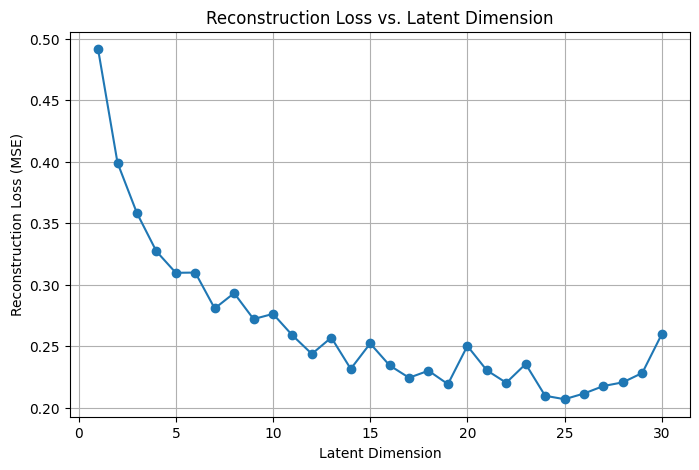

In [ ]:
# ---------- AutoEncoder stub ----------
class AE(nn.Module):
    def __init__(self, in_dim, latent_dim=10):
        super().__init__()
        # TODO: define encoder / decoder layers
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, in_dim)
            # 출력층은 선형, MSELoss 사용 시 활성화 함수 없음
        )

    def forward(self, x):
        # TODO: forward pass
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)

        return reconstructed
    
    def encode(self, x):
        return self.encoder(x)

def train_ae(x_np, latent_dim, epochs):
    """Returns latent representation (np.ndarray)."""
    # TODO: build model, optimizer, loss, training loop
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x_tensor = torch.tensor(x_np, dtype=torch.float32)
    dataset = TensorDataset(x_tensor)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = AE(in_dim=x_np.shape[1], latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch in loader:
            inputs = batch[0].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)
        epoch_loss /= len(loader.dataset)
        # print(f"Epoch {epoch+1}, Loss: {epoch_loss:.6f}")

    # 학습 후 latent representation 추출
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(device)
        latent = model.encode(x_tensor).cpu().numpy()

    return latent, epoch_loss


# latent_dim = 10
# epochs = 100
# X_ae, loss = train_ae(X_std, latent_dim, epochs)
# -------------------------------------
losses = []
dims = list(range(1, 31))  # 보통 dim=0은 무의미하니 1부터

for latent_dim in dims:
    X_ae, loss = train_ae(X_std, latent_dim=latent_dim, epochs=100)
    losses.append(loss)

plt.figure(figsize=(8, 5))
plt.plot(dims, losses, marker='o')
plt.title('Reconstruction Loss vs. Latent Dimension')
plt.xlabel('Latent Dimension')
plt.ylabel('Reconstruction Loss (MSE)')
plt.grid(True)
plt.show()

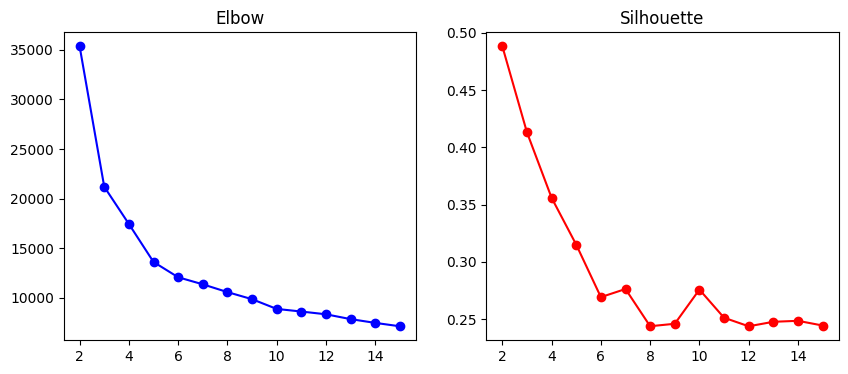

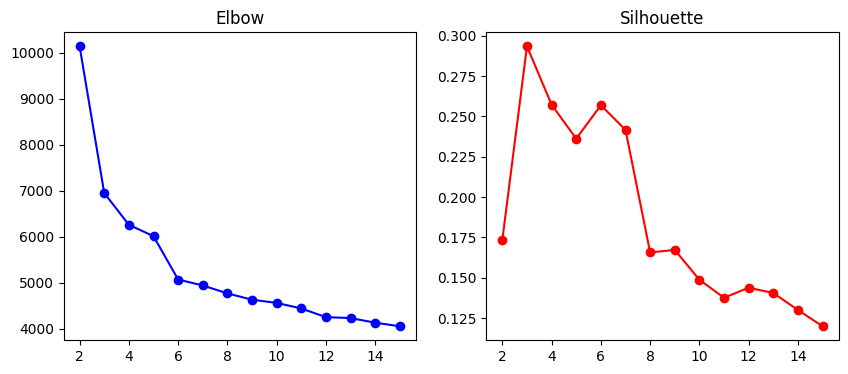

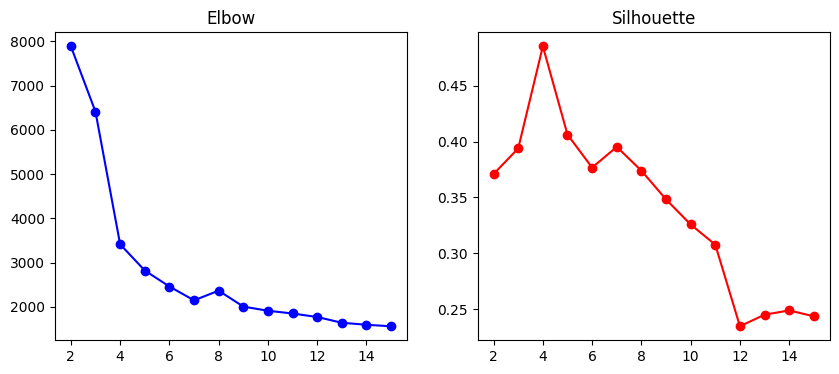

In [65]:
# ---------- 4. Helper: k-Means Elbow & Silhouette ----------
def elbow_silhouette_plot(X, k_range=range(2, 16)):
    inertia, sil = [], []
    for k in k_range:
        # TODO: run KMeans, get inertia and Silhouette scores
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(X)
        inertia.append(model.inertia_)
        sil.append(silhouette_score(X, labels))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(k_range, inertia, 'bo-')
    ax1.set_title("Elbow")
    
    ax2.plot(k_range, sil, 'ro-')
    ax2.set_title("Silhouette")
    
    plt.show()
    # TODO: select best k by inspecting the plots

run_kmeans_raw = elbow_silhouette_plot(X_filled)
run_kmeans_pca = elbow_silhouette_plot(X_pca)
run_kmeans_ae = elbow_silhouette_plot(train_ae(X_std, latent_dim=10, epochs=100)[0])

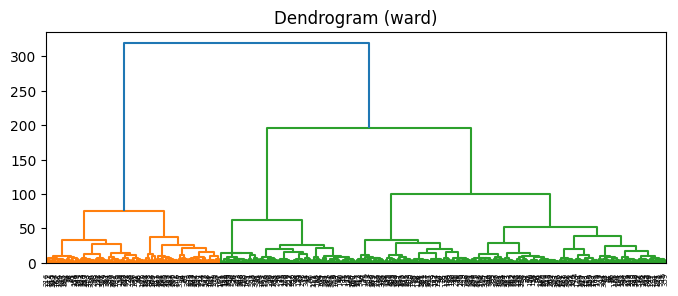

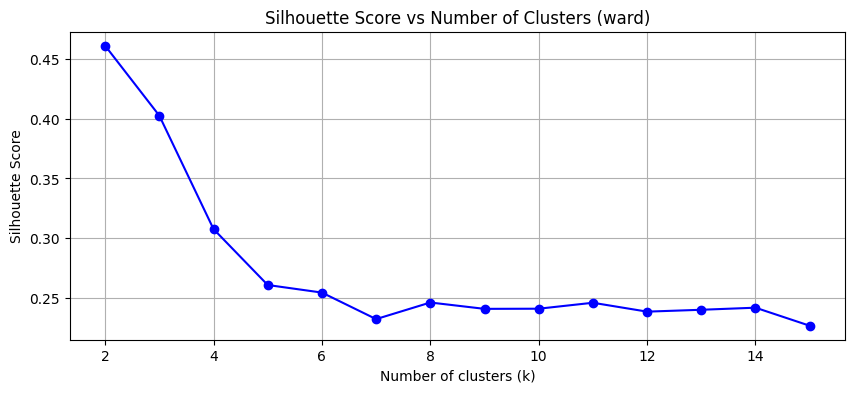

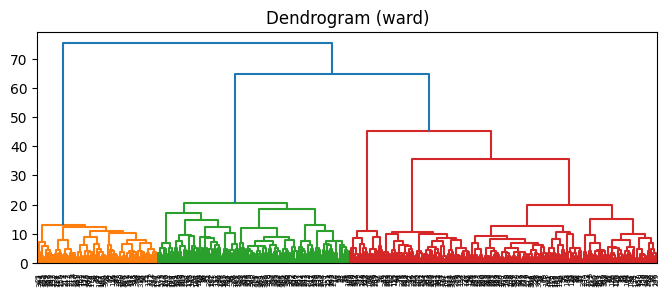

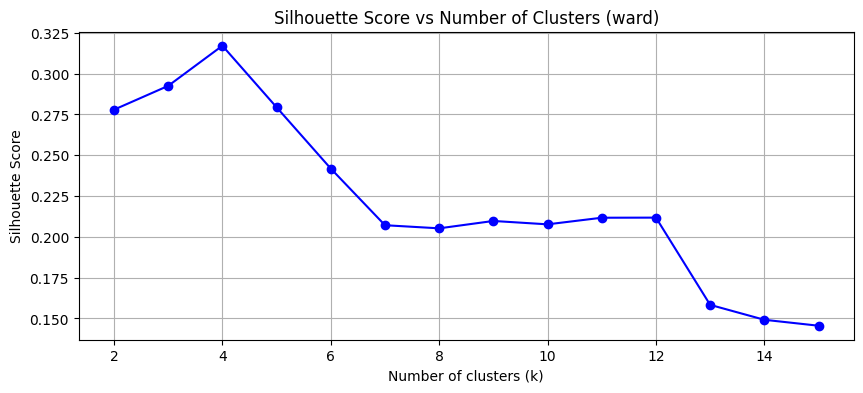

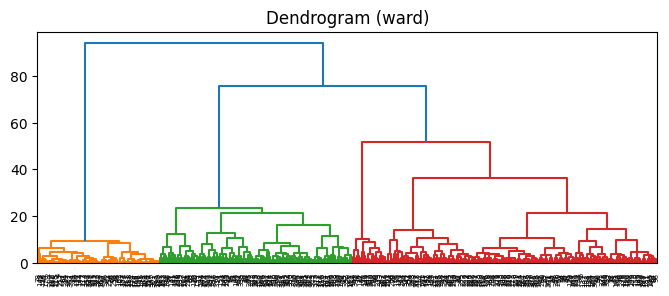

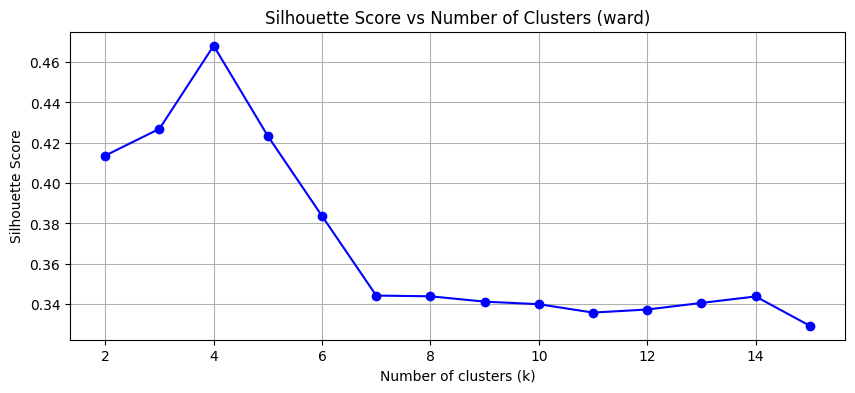

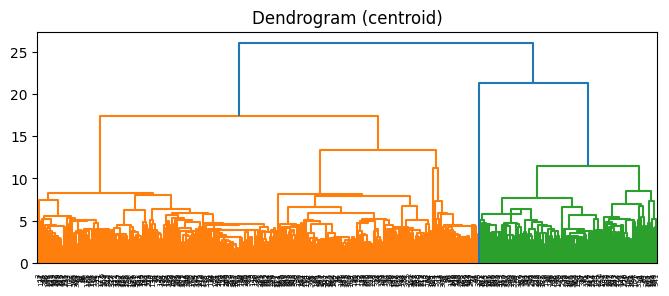

InvalidParameterError: The 'linkage' parameter of AgglomerativeClustering must be a str among {'ward', 'single', 'average', 'complete'}. Got 'centroid' instead.

In [68]:
# ---------- 5. Helper: Agglomerative Dendrogram ----------
from scipy.cluster.hierarchy import linkage, dendrogram

def dendro_plot(X, method):  # TODO: try other linkage methods
    Z =  linkage(X, method=method) # TODO: get linkage
    plt.figure(figsize=(8, 3))
    # TODO: plot dendrogram
    dendrogram(Z)
    plt.title(f"Dendrogram ({method})")
    plt.show()
    # TODO: compute Silhouette for k=2..15

def run_agglomerative(X, method):
    sil = []
    k_range = range(2, 16)
    for k in k_range:
        model = AgglomerativeClustering(n_clusters=k, linkage=method)
        labels = model.fit_predict(X)
        sil.append(silhouette_score(X, labels))

    plt.figure(figsize=(10, 4))
    plt.plot(k_range, sil, 'bo-')
    plt.title(f'Silhouette Score vs Number of Clusters ({method})')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

X_ae = train_ae(X_std, latent_dim=10, epochs=100)[0]
methods = ['ward', 'centroid', 'weighted']
Xs = [X_filled, X_pca, X_ae]

for method in methods:
    for X in Xs:
        dendro_plot(X, method)
        run_agglomerative(X, method)

/opt/homebrew/Caskroom/miniforge/base/envs/EE214/lib/python3.13/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/homebrew/Caskroom/miniforge/base/envs/EE214/lib/python3.13/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


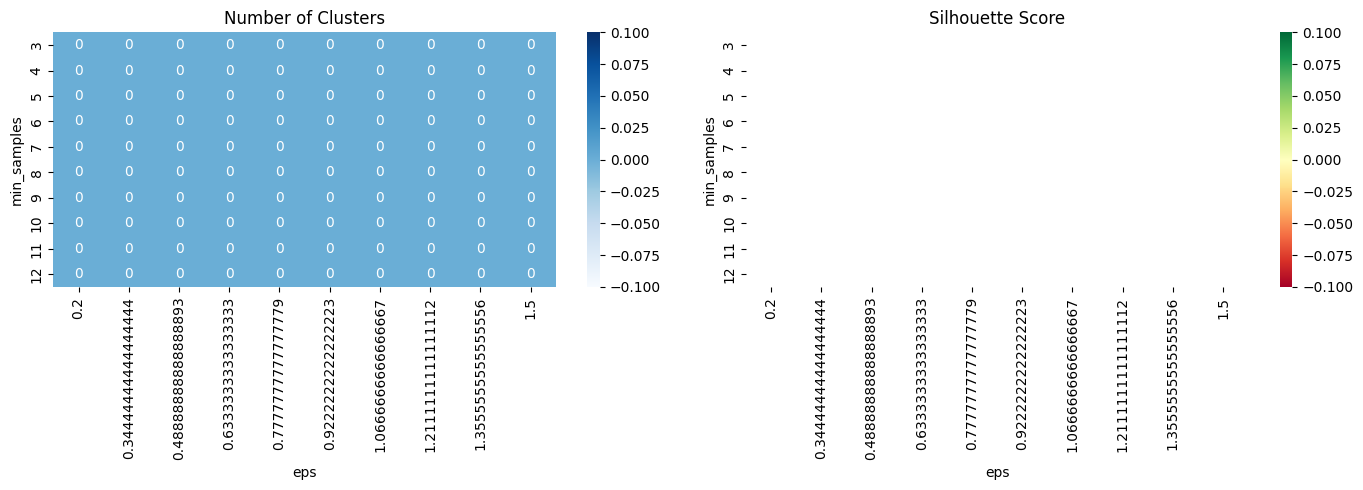

No valid silhouette scores (all NaN). Try different parameter ranges.


/opt/homebrew/Caskroom/miniforge/base/envs/EE214/lib/python3.13/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/homebrew/Caskroom/miniforge/base/envs/EE214/lib/python3.13/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


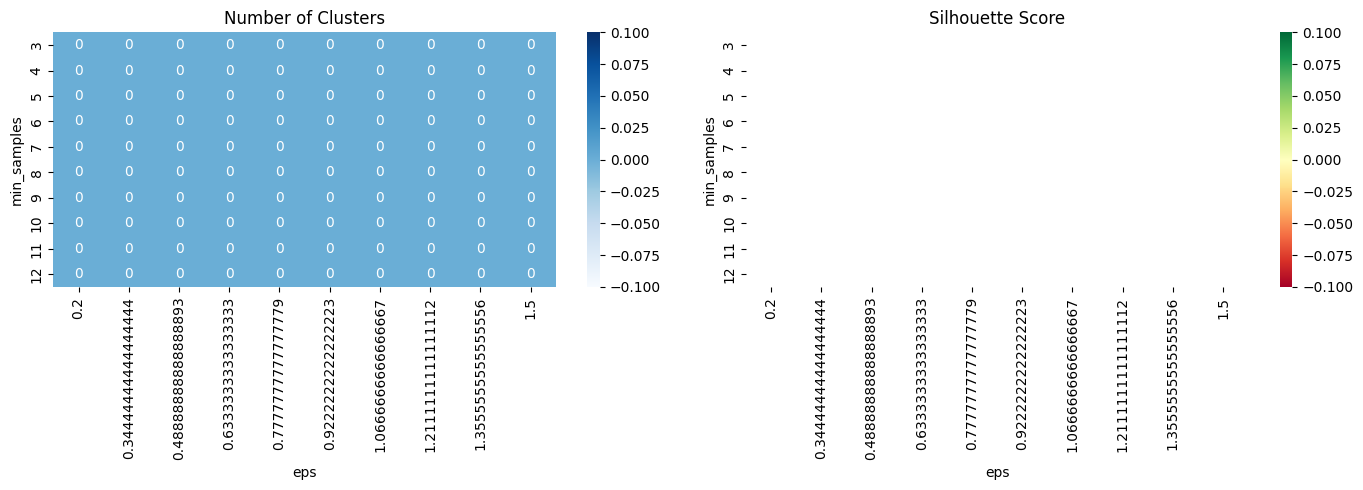

No valid silhouette scores (all NaN). Try different parameter ranges.


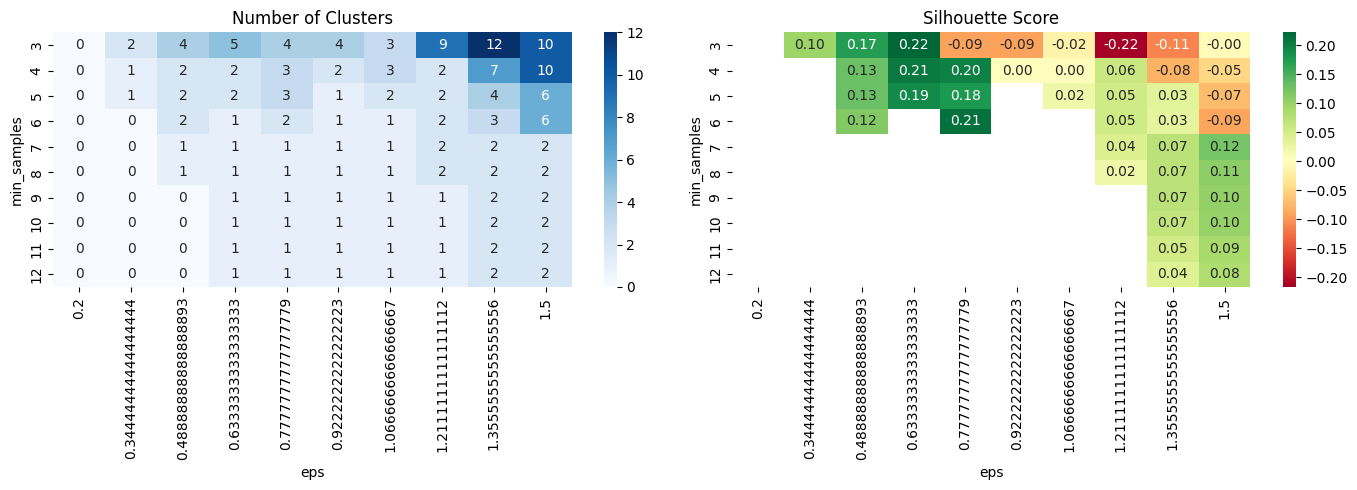

Best params: eps=0.6333333333333333, min_samples=3.0, clusters=5.0, silhouette=0.2224


In [71]:
# ---------- 6. Helper: DBSCAN grid heatmap ----------
def dbscan_heatmap(X, eps_vals, min_samples_vals):
    # TODO: implement grid search heatmap for DBSCAN

    """
    High-level outline:
        1. Iterate over every (eps, min_samples) combination.
        2. Fit DBSCAN, record:
            - number of clusters (ignore noise label -1)
            - Silhouette score (set to NaN if clusters < 2)
        3. Pivot the results into two matrices:
            - heatmap of cluster counts
            - heatmap of Silhouette scores
        4. Display the two heatmaps side by side.
        5. After inspecting the visuals, manually choose the
            best (eps, min_samples) pair for your final model.
    """
    # TODO: implement the loop, DataFrame creation, seaborn heatmaps,
    #       and return or log the chosen parameters.

    # 1. Iterate over every (eps, min_samples) combinations.
    results = []
    for eps in eps_vals:
        for min_samples in min_samples_vals:
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(X)

            # 2-1. number of clusters (ignore noise label -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            # 2-2. Silhouette score (set to NaN if clusters < 2)
            if n_clusters >= 2:
                score = silhouette_score(X, labels)
            else:
                score = np.nan

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'silhouette': score
            })

    df = pd.DataFrame(results)

    # 3. Pivot the results into two matrices:
    # 3-1. heatmap of cluster counts
    cluster_mat = df.pivot(index='min_samples', columns='eps', values='n_clusters')
    # 3-2. heatmap of Silhouette scores
    sil_mat = df.pivot(index='min_samples', columns='eps', values='silhouette')

    # 4. Display the two heatmaps side by side.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    sns.heatmap(cluster_mat, annot=True, fmt='.0f', cmap='Blues', ax=ax1)
    ax1.set_title('Number of Clusters')
    ax1.set_xlabel('eps')
    ax1.set_ylabel('min_samples')

    sns.heatmap(sil_mat, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax2)
    ax2.set_title('Silhouette Score')
    ax2.set_xlabel('eps')
    ax2.set_ylabel('min_samples')

    plt.tight_layout()
    plt.show()

    # 5. After inspecting the visuals, manually choose the best (eps, min_samples) pair for your final model.
    valid_df = df.dropna(subset=['silhouette'])

    if not valid_df.empty:
        best_row = valid_df.loc[valid_df['silhouette'].idxmax()]
        print(f"Best params: eps={best_row['eps']}, min_samples={best_row['min_samples']}, "
          f"clusters={best_row['n_clusters']}, silhouette={best_row['silhouette']:.4f}")
    else:
        print("No valid silhouette scores (all NaN). Try different parameter ranges.")


eps_vals = np.linspace(0.2, 1.5, 10)
min_samples_vals = range(3, 13)

run_dbscan_raw = dbscan_heatmap(X_filled, eps_vals, min_samples_vals)
run_dbscan_pca = dbscan_heatmap(X_pca, eps_vals, min_samples_vals)
run_dbscan_ae = dbscan_heatmap(X_ae, eps_vals, min_samples_vals)

In [ ]:
# ---------- 7. Final clustering (student-chosen params) ----------
# TODO: run k-Means, Agglomerative, DBSCAN with the parameters you selected
# labels_km = 
# labels_agg = 
# labels_db = 




In [ ]:
# ---------- 8. Visualisation helper ----------
def scatter_2d(X2, labels, title):
    plt.figure(figsize=(4, 4))
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap="tab10", s=8)
    plt.title(title)
    plt.show()

# Example:
# scatter_2d(X_pca, labels_km, "Dermatology: k-Means on PCA")




In [ ]:
# ---------- 9. UNKNOWN DATASET ----------
# Repeat steps 4–8 for X_unknown (skip AE training).
